In [ ]:
import os
current_dir = os.getcwd()
print("Direccion actual:", current_dir)

os.chdir('/content/drive/MyDrive/Colab Notebooks/FDM_WCNN')
print("Nuevo directorio:", os.getcwd())

Direccion actual: /content
Nuevo directorio: /content/drive/MyDrive/Colab Notebooks/FDM_WCNN


In [ ]:
import pywt, cv2, time, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing import image
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, GlobalAveragePooling2D, Flatten, Dropout, Dense
#from keras.layers import Rescaling, RandomFlip, RandomBrightness, RandomContrast, RandomTranslation, RandomCrop

In [ ]:
from utils.manager_checkpointers import get_checkpoints
from utils.manage_csv_logger import get_csv_logger
from utils import export_metrics
from utils.test_manual_model import show_test

In [ ]:
# Configurar las semillas para la reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print(f'SEED: {SEED}')

SEED: 42


In [ ]:
# Definir una función de normalización
def normalize_data(data):
    # Inicializar el escalador
    scaler = MinMaxScaler()
    return scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

In [ ]:
def export_model(wavelet, experiment, model):
    base_dir = 'saves/checkpointer'
    model_save_dir = os.path.join(base_dir, f'{wavelet}-experiment')
    subdirectories = ['model_save']
    sub_dirs = [os.path.join(model_save_dir, sub) for sub in subdirectories]
    export_metrics.create_directories(model_save_dir, *sub_dirs)

    model_name_h5 = os.path.join(sub_dirs[0], f'model_FDM-{wavelet}-{experiment}-(HDF5)).h5')
    model_name_keras = os.path.join(sub_dirs[0], f'model_FDM-{wavelet}-{experiment}-(keras)).keras')

    model.save(model_name_h5)
    model.save(model_name_keras)
    print('Saved trained model successfully')

In [ ]:
#Parametros para iniciales de imagenes
image_size = (300, 300)
n_imagenes = 100
#Inicializacion de las listas de datos
data = []
labels = []
labelsDWT =[]
#dataDWT_cA3, dataDWT_cH3, dataDWT_cV3, dataDWT_cD3 = ([] for _ in range(4))
# Lista de categorías
dataset_dir = os.path.join("FMD")
categorias = os.listdir(dataset_dir)
print(f'Categorías: {categorias}')

#wavelets_prueba = ['haar', 'db10', 'sym2', 'coif1', 'bior1.1']
wavelets =  ['haar', 'db10', 'sym2', 'coif1', 'bior1.1']
niveles3 = 3

Categorías: ['stone', 'water', 'metal', 'paper', 'foliage', 'glass', 'leather', 'plastic', 'wood', 'fabric']


In [ ]:
# Cargar imágenes y asignar etiquetas
start_time = time.time()
for i, categoria in enumerate(categorias):
    categoria_path = os.path.join(dataset_dir, categoria)
    for imagen_file in os.listdir(categoria_path)[:n_imagenes]:
        imagen_path = os.path.join(categoria_path, imagen_file)

        # Verificar si el archivo es una imagen
        if os.path.splitext(imagen_file)[1].lower() in ['.png', '.jpg', '.jpeg', '.bmp']:
            # Cargar y preprocesar la imagen con Keras (a escala de grises)
            img = image.load_img(imagen_path, target_size=image_size, color_mode="grayscale")
            img_array = image.img_to_array(img)
            # Agregar datos y etiquetas
            data.append(img_array)
            labels.append(i)
        else:
            None#print(f"Archivo no válido: {imagen_file}")
print(f'Datos cargados con exito con {len(data)} datos y {len(labels)} etiquetas')
# Convertir a matrices NumPy
data = np.array(data, dtype=np.float64)
labels = np.array(labels)

# Información sobre la forma de los conjuntos de datos
#for i, categoria in enumerate(categorias):
#    print(f'Data {categoria.capitalize()}:', data[labels == i].shape)
for categoria in categorias:
    num_muestras = sum(1 for label in labels if label == categorias.index(categoria))
    print(f'Data {categoria.capitalize()}: ({num_muestras}, {data[labels == categorias.index(categoria)].shape[1:]})')
print(f"Dimensiones de datos: {data.shape}")
print(f"Dimensiones de etiquetas: {labels.shape}")

end_time = time.time()
elapsed_time_up = end_time - start_time
print(f"Tiempo transcurrido: {elapsed_time_up} segundos")

Datos cargados con exito con 997 datos y 997 etiquetas
Data Stone: (100, (300, 1))
Data Water: (100, (300, 1))
Data Metal: (100, (300, 1))
Data Paper: (100, (300, 1))
Data Foliage: (99, (300, 1))
Data Glass: (100, (300, 1))
Data Leather: (100, (300, 1))
Data Plastic: (100, (300, 1))
Data Wood: (100, (300, 1))
Data Fabric: (98, (300, 1))
Dimensiones de datos: (997, 300, 300, 1)
Dimensiones de etiquetas: (997,)
Tiempo transcurrido: 24.19256043434143 segundos


In [ ]:
# Codificar las etiquetas a one-hot encoding
labels_or = to_categorical(labels, num_classes=10)
print(labels_or.shape)

# Aumentar etiquetas en 4
labelsDWT = np.repeat(labels, 4)
print(f'Número de nuevas etiquetas: {len(labelsDWT)}, {labelsDWT.shape}')

(997, 10)
Número de nuevas etiquetas: 3988, (3988,)


In [ ]:
#---------------Extraccion de caracteristicas Wavelet---------------#
dataDWT_wavelets = {wavelet: [] for wavelet in wavelets}
labelsDWT_wavelets = []
elapsed_times_wavelet = {}


for wavelet in wavelets:
    start_time_wavelet = time.time()
    dataDWT_cA3, dataDWT_cH3, dataDWT_cV3, dataDWT_cD3 = ([] for _ in range(4))

    for imagen_array in data:
        if len(imagen_array.shape) == 3:
            imagen_array = imagen_array[:, :, 0]

        coeffs = pywt.wavedec2(imagen_array, wavelet, level=niveles3)
        (cA, (cH1, cV1, cD1), (cH2, cV2, cD2), (cH3, cV3, cD3)) = coeffs

        dataDWT_cA3.append(cA)
        dataDWT_cH3.append(cH1)
        dataDWT_cV3.append(cV1)
        dataDWT_cD3.append(cD1)

    dataDWT_cA3, dataDWT_cH3, dataDWT_cV3, dataDWT_cD3 = map(np.array, (dataDWT_cA3, dataDWT_cH3, dataDWT_cV3, dataDWT_cD3))
    dataDWT3 = np.concatenate((dataDWT_cA3, dataDWT_cH3, dataDWT_cV3, dataDWT_cD3), axis=0)
    dataDWT_wavelets[wavelet] = dataDWT3

    end_time_wavelet = time.time()
    elapsed_time_wavelet = end_time_wavelet - start_time_wavelet
    elapsed_times_wavelet[wavelet] = elapsed_time_wavelet

    print(f'Descomposición de 3 nivel completada con éxito para {wavelet}...')

    print(f'Tiempo transcurrido: {end_time_wavelet[wavelet]} segundos')

Descomposición de 3 nivel completada con éxito para haar...
Descomposición de 3 nivel completada con éxito para db10...
Descomposición de 3 nivel completada con éxito para sym2...
Descomposición de 3 nivel completada con éxito para coif1...
Descomposición de 3 nivel completada con éxito para bior1.1...
Tiempo transcurrido: 13.070220470428467 segundos


In [ ]:
# Imprimir las dimensiones de cada matriz
print("Dimensiones de dataDWT_cA3:", dataDWT3.shape)
#---------------------------------------------------------#

# Imprimir información sobre los datos extraídos para cada wavelet
for wavelet, dataDWT3 in dataDWT_wavelets.items():
    print(f'Wavelet: {wavelet}')
    print(f'Número de elementos: {dataDWT3.shape[0]}')
    print(f'Tamaño de cada elemento: {dataDWT3.shape[1:]}')
    print()


Dimensiones de dataDWT_cA3: (3988, 38, 38)
Wavelet: haar
Número de elementos: 3988
Tamaño de cada elemento: (38, 38)

Wavelet: db10
Número de elementos: 3988
Tamaño de cada elemento: (54, 54)

Wavelet: sym2
Número de elementos: 3988
Tamaño de cada elemento: (40, 40)

Wavelet: coif1
Número de elementos: 3988
Tamaño de cada elemento: (41, 41)

Wavelet: bior1.1
Número de elementos: 3988
Tamaño de cada elemento: (38, 38)



In [ ]:
# Codificar las etiquetas a one-hot encoding
labels_DWT_oh = to_categorical(labelsDWT, num_classes=10)
print(labels_DWT_oh.shape)
print(labels_DWT_oh[800])

(3988, 10)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
for wavelet in wavelets:
    data = dataDWT_wavelets[wavelet]
    print(f'Statistics for wavelet: {wavelet}')
    print(f'Mean: {np.mean(data)}, Std: {np.std(data)}, Min: {np.min(data)}, Max: {np.max(data)}')
    print(f'Shape: {data.shape}')
    print()

Statistics for wavelet: haar
Mean: 312.41519164487926, Std: 578.8332035520134, Min: -839.5000000000003, Max: 2040.000000000001
Shape: (3988, 38, 38)

Statistics for wavelet: db10
Mean: 311.9750489287017, Std: 583.8063676411406, Min: -1013.4828185624385, Max: 2617.7448164715415
Shape: (3988, 54, 54)

Statistics for wavelet: sym2
Mean: 312.0769459622679, Std: 580.5167912983209, Min: -934.559375546862, Max: 2234.6228295127457
Shape: (3988, 40, 40)

Statistics for wavelet: coif1
Mean: 311.7888359999495, Std: 580.4226071728327, Min: -830.1539907012715, Max: 2215.896755402058
Shape: (3988, 41, 41)

Statistics for wavelet: bior1.1
Mean: 312.41519164487926, Std: 578.8332035520134, Min: -839.5000000000003, Max: 2040.000000000001
Shape: (3988, 38, 38)



In [ ]:
# Diccionarios para almacenar los datos divididos y normalizados
X_train_wavelets = {}
X_test_wavelets = {}
y_train_wavelets = {}
y_test_wavelets = {}

In [ ]:
# Normalización y preparación de datos para entrenamiento y evaluación
for wavelet, dataDWT in dataDWT_wavelets.items():
    print(f'Preparando datos para la wavelet: {wavelet}')

    labels_DWT_oh = to_categorical(labelsDWT, num_classes=10)

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train3, X_test3, y_train3, y_test3 = train_test_split(dataDWT, labels_DWT_oh, test_size=0.20, random_state=SEED)

    print(f'Dimensión de X_train: {X_train3.shape}')
    print(f'Dimensión de X_test: {X_test3.shape}')
    print(f'Dimensión de y_train: {y_train3.shape}')
    print(f'Dimensión de y_test: {y_test3.shape}')

    # Normalizar los datos
    X_train_normalized = normalize_data(X_train3)
    X_test_normalized = normalize_data(X_test3)

    # Añadir dimensión del canal
    X_train_normalized = np.expand_dims(X_train_normalized, axis=-1)
    X_test_normalized = np.expand_dims(X_test_normalized, axis=-1)

    print(f'Dimensión de X_train_normalized: {X_train_normalized.shape}')
    print(f'Dimensión de X_test_normalized: {X_test_normalized.shape}')
    print()

    # Almacenar los datos normalizados en los diccionarios
    X_train_wavelets[wavelet] = X_train_normalized
    X_test_wavelets[wavelet] = X_test_normalized
    y_train_wavelets[wavelet] = y_train3
    y_test_wavelets[wavelet] = y_test3


Preparando datos para la wavelet: haar
Dimensión de X_train: (3190, 38, 38)
Dimensión de X_test: (798, 38, 38)
Dimensión de y_train: (3190, 10)
Dimensión de y_test: (798, 10)
Dimensión de X_train_normalized: (3190, 38, 38, 1)
Dimensión de X_test_normalized: (798, 38, 38, 1)

Preparando datos para la wavelet: db10
Dimensión de X_train: (3190, 54, 54)
Dimensión de X_test: (798, 54, 54)
Dimensión de y_train: (3190, 10)
Dimensión de y_test: (798, 10)
Dimensión de X_train_normalized: (3190, 54, 54, 1)
Dimensión de X_test_normalized: (798, 54, 54, 1)

Preparando datos para la wavelet: sym2
Dimensión de X_train: (3190, 40, 40)
Dimensión de X_test: (798, 40, 40)
Dimensión de y_train: (3190, 10)
Dimensión de y_test: (798, 10)
Dimensión de X_train_normalized: (3190, 40, 40, 1)
Dimensión de X_test_normalized: (798, 40, 40, 1)

Preparando datos para la wavelet: coif1
Dimensión de X_train: (3190, 41, 41)
Dimensión de X_test: (798, 41, 41)
Dimensión de y_train: (3190, 10)
Dimensión de y_test: (798, 

In [ ]:
# Verificar el almacenamiento de los datos
for wavelet in wavelets:
    print(f'Datos almacenados para la wavelet: {wavelet}')
    print(f'Dimensión de X_train_wavelets[{wavelet}]: {X_train_wavelets[wavelet].shape}')
    print(f'Dimensión de X_test_wavelets[{wavelet}]: {X_test_wavelets[wavelet].shape}')
    print(f'Dimensión de y_train_wavelets[{wavelet}]: {y_train_wavelets[wavelet].shape}')
    print(f'Dimensión de y_test_wavelets[{wavelet}]: {y_test_wavelets[wavelet].shape}')
    print()

Datos almacenados para la wavelet: haar
Dimensión de X_train_wavelets[haar]: (3190, 38, 38, 1)
Dimensión de X_test_wavelets[haar]: (798, 38, 38, 1)
Dimensión de y_train_wavelets[haar]: (3190, 10)
Dimensión de y_test_wavelets[haar]: (798, 10)

Datos almacenados para la wavelet: db10
Dimensión de X_train_wavelets[db10]: (3190, 54, 54, 1)
Dimensión de X_test_wavelets[db10]: (798, 54, 54, 1)
Dimensión de y_train_wavelets[db10]: (3190, 10)
Dimensión de y_test_wavelets[db10]: (798, 10)

Datos almacenados para la wavelet: sym2
Dimensión de X_train_wavelets[sym2]: (3190, 40, 40, 1)
Dimensión de X_test_wavelets[sym2]: (798, 40, 40, 1)
Dimensión de y_train_wavelets[sym2]: (3190, 10)
Dimensión de y_test_wavelets[sym2]: (798, 10)

Datos almacenados para la wavelet: coif1
Dimensión de X_train_wavelets[coif1]: (3190, 41, 41, 1)
Dimensión de X_test_wavelets[coif1]: (798, 41, 41, 1)
Dimensión de y_train_wavelets[coif1]: (3190, 10)
Dimensión de y_test_wavelets[coif1]: (798, 10)

Datos almacenados para 

In [ ]:
INIT_LR = 1e-4  # Valor inicial de learning rate.
epochs = 200  # Cantidad de iteraciones completas al conjunto de imágenes de entrenamiento
batch_size = 32  # Cantidad de imágenes que se toman a la vez en memoria
# img_width, img_height = 300, 300
# img_width1, img_height1 = 150, 150
# img_width2, img_height2 = 75, 75
# img_width3, img_height3 = 38, 38
img_shape = X_train_normalized[0].shape
n_class=10
experimento = 29
dropout = 0.2
loss_funtion = 'categorical_crossentropy'
metric_acc = 'accuracy'

In [ ]:
def cnn_model(input_shape, num_classes):
    #-------------Arquitectura del modelo CNN---------------------#
    model = Sequential()
    model.add(Input(shape=input_shape))
    #model.add(Rescaling(1./255, name='Rescaling'))
    model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu', name='Conv2D_1'))
    #model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu', name='Conv2D_2'))
    #model.add(RandomBrightness(factor=0.2, name='Bringhtness'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='MaxPool_1'))
    model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu', name='Conv2D_3'))
    #model.add(RandomTranslation(height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3),fill_mode="reflect", name='RandomTranslation'))
    model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu', name='Conv2D_4'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='MaxPool_2'))
    model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu', name='Conv2D_5'))
    #model.add(RandomFlip("horizontal_and_vertical", seed=None, name='RandomFlip'))
    model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu', name='Conv2D_6'))
    #model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='MaxPool_3'))
    #model.add(Conv2D(512, (3,3), strides=1, padding='same', activation='relu', name='Conv2D_7'))
    #model.add(Conv2D(512, (3,3), strides=1, padding='same', activation='relu', name='Conv2D_8'))
    #model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='MaxPool_3'))
    model.add(GlobalAveragePooling2D(name='GlobalAvgPool'))
    model.add(Flatten(name='Flatten'))
    model.add(Dropout(0.3, name='Dropout'))
    model.add(Dense(num_classes, activation='softmax', name='Output'))

    # Compilación del modelo
    adam_optimizer = Adam(learning_rate=INIT_LR, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=adam_optimizer, loss=loss_funtion, metrics=[metric_acc])

    return model


In [ ]:
# Diccionario para guardar las historias de entrenamiento y tiempos
training_histories = {}
training_times = {}
# Diccionario para almacenar los resultados de evaluación
evaluation_results = {}

for wavelet in wavelets:
    print(f'Entrenando con la wavelet: {wavelet}')

    # Limpiar la sesión previa para liberar memoria
    K.clear_session()

    # Obtener los datos para la wavelet actual
    X_train = X_train_wavelets[wavelet]
    X_test = X_test_wavelets[wavelet]
    y_train = y_train_wavelets[wavelet]
    y_test = y_test_wavelets[wavelet]

    # Crear el modelo
    input_shape = X_train.shape[1:]
    model = cnn_model(input_shape, n_class)

    # Mostrar el resumen del modelo
    model.summary()

    # Definir callbacks
    checkpoints = get_checkpoints(wavelet, experimento)
    early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='max', restore_best_weights=True)
    csv_logger = get_csv_logger(wavelet, experimento)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.001)

    start_time = time.time()
    # Entrenar el modelo
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=[csv_logger, reduce_lr, checkpoints])
    end_time = time.time()
    elapsed_time = end_time - start_time
    training_times[wavelet] = elapsed_time


    print(f'Tiempo de entrenamiento para {wavelet}: {elapsed_time:.2f} segundos')

    # Guardar las métricas de entrenamiento
    training_histories[wavelet] = history.history

        # Guardar el modelo entrenado
    export_model(wavelet, experimento, model)

Entrenando con la wavelet: haar
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 38, 38, 64)        640       
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 19, 19, 64)        0         
                                                                 
 Conv2D_3 (Conv2D)           (None, 19, 19, 128)       73856     
                                                                 
 Conv2D_4 (Conv2D)           (None, 19, 19, 128)       147584    
                                                                 
 MaxPool_2 (MaxPooling2D)    (None, 10, 10, 128)       0         
                                                                 
 Conv2D_5 (Conv2D)           (None, 10, 10, 256)       295168    
                                                                 
 Conv2D_6 (Conv2D)      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Se truncaron las últimas líneas 5000 del resultado de transmisión.
Epoch 108: val_accuracy did not improve from 0.44671

Epoch 108: val_loss did not improve from 1.13356
80/80 [==============================] - 1s 12ms/step - loss: 1.1052 - accuracy: 0.4718 - val_loss: 1.1428 - val_accuracy: 0.4279 - lr: 1.0000e-04
Epoch 109/200
77/80 [===========================>..] - ETA: 0s - loss: 1.0888 - accuracy: 0.4899
Epoch 109: accuracy did not improve from 0.49922

Epoch 109: loss did not improve from 1.07886

Epoch 109: val_accuracy did not improve from 0.44671

Epoch 109: val_loss did not improve from 1.13356
80/80 [==============================] - 1s 12ms/step - loss: 1.0859 - accuracy: 0.4910 - val_loss: 1.1766 - val_accuracy: 0.4216 - lr: 1.0000e-04
Epoch 110/200
78/80 [============================>.] - ETA: 0s - loss: 1.0769 - accuracy: 0.4916
Epoch 110: accuracy did not improve from 0.49922

Epoch 110: loss improved from 1.07886 to 1.07666, saving model to saves/checkpointer/sym2-exp

In [ ]:
# Diccionario para almacenar los resultados de evaluación
evaluation_results = {}

for wavelet in wavelets:
    print(f'Evaluando el modelo para la wavelet: {wavelet}')

    # Obtener los datos para la wavelet actual
    X_test = X_test_wavelets[wavelet]
    y_test = y_test_wavelets[wavelet]

    # Evaluar el modelo en el conjunto de prueba
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Precisión del modelo en los datos de prueba para {wavelet}: {accuracy*100:.2f}%')
    print(f'Función de pérdida en los datos de prueba para {wavelet}: {loss:.4f}')

    # Predicciones del conjunto de prueba
    predictions = model.predict(X_test)
    y_pred_classes = np.argmax(predictions, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Errors are difference between predicted labels and true labels
    errors = (y_pred_classes != y_test_classes)
    Y_pred_classes_errors = y_pred_classes[errors]
    Y_pred_errors = predictions[errors]
    Y_true_errors = y_test_classes[errors]
    X_test_errors = X_test[errors]

    # Guardar resultados de evaluación en el diccionario
    evaluation_results[wavelet] = {
        'loss': loss,
        'accuracy': accuracy,
        'predictions': predictions,
        'y_pred_classes': y_pred_classes,
        'y_test_classes': y_test_classes,
        'errors': errors,
        'Y_pred_classes_errors': Y_pred_classes_errors,
        'Y_pred_errors': Y_pred_errors,
        'Y_true_errors': Y_true_errors,
        'X_test_errors': X_test_errors
    }

Evaluando el modelo para la wavelet: haar
25/25 [==============================] - 0s 4ms/step - loss: 1.3654 - accuracy: 0.3897
Precisión del modelo en los datos de prueba para haar: 38.97%
Función de pérdida en los datos de prueba para haar: 1.3654
25/25 [==============================] - 0s 3ms/step
Evaluando el modelo para la wavelet: db10
25/25 [==============================] - 0s 6ms/step - loss: 7.7326 - accuracy: 0.1880
Precisión del modelo en los datos de prueba para db10: 18.80%
Función de pérdida en los datos de prueba para db10: 7.7326
25/25 [==============================] - 0s 4ms/step
Evaluando el modelo para la wavelet: sym2
25/25 [==============================] - 0s 5ms/step - loss: 1.3771 - accuracy: 0.4048
Precisión del modelo en los datos de prueba para sym2: 40.48%
Función de pérdida en los datos de prueba para sym2: 1.3771
25/25 [==============================] - 0s 3ms/step
Evaluando el modelo para la wavelet: coif1
25/25 [==============================] - 0s 5

In [ ]:
# Diccionario para almacenar todos los parámetros
training_info = {}

for wavelet in wavelets:
    training_info[wavelet] = {
        'history': training_histories[wavelet],
        'training_time': training_times[wavelet]
        'img_shape_DWT': img_shape_DWT
    }

# información
#for wavelet, info in training_info.items():
#    print(f'Wavelet: {wavelet}')
#    print(f'Tiempo de entrenamiento: {info["training_time"]:.2f} segundos')
#    print(f'Historia de entrenamiento: {info["history"].keys()}')
#    print()

Parameters saved successfully.
Results saved successfully.
Gráficos guardados exitosamente.
Check predictions saved successfully.
Found 311 correct labels
Found 487 incorrect labels
Classification report saved successfully.
All parameters saved successfully.
Results saved successfully.
Exactitud: 38.97%
Precisión: 0.38
Matriz de Confusión:
[[51 42  3  0  0  0  0  0  0  0]
 [21 51  2  0  0  0  0  0  0  0]
 [16 23  3 26 23  0  0  0  0  1]
 [ 0  0  1 47 33  2  1  0  0  0]
 [ 0  0  3 36 31  1  2  0  0  0]
 [ 0  0  0  0  0 17 62  0  0  0]
 [ 0  0  0  0  0 10 62  1  0  0]
 [ 0  0  0  0  0 14 32 12  3  6]
 [ 0  0  0  1  0 14  4 15 11 37]
 [ 0  0  0  0  0 21  8 11 12 26]]
Parameters saved successfully.
Results saved successfully.
Gráficos guardados exitosamente.
Check predictions saved successfully.
Found 150 correct labels
Found 648 incorrect labels
Classification report saved successfully.
All parameters saved successfully.
Results saved successfully.
Exactitud: 18.80%
Precisión: 0.48
Matriz

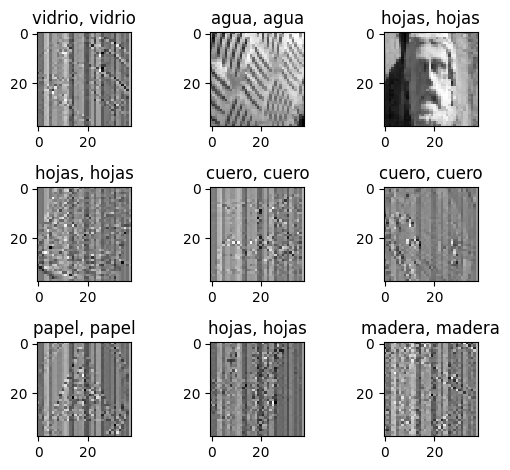

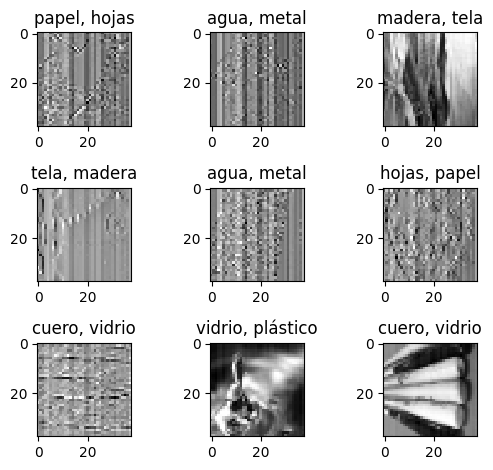

In [ ]:
# Exportar métricas y graficar para cada wavelet
for wavelet, eval_data in evaluation_results.items():

    num_train_samples = X_train.shape[0]
    num_test_samples = X_test.shape[0]
    num_validation_samples = int(0.2 * num_train_samples)

    params_dict = {
        "wavelet": wavelet,
        "image_size": image_size,
        "image_size_DWT": img_shape,
        "n_imagenes": n_imagenes,
        "nivel_DWT": niveles3,
        "INIT_LR": INIT_LR,
        "epochs": epochs,
        "batch_size": batch_size,
        "num_class": n_class,
        "experimento": experimento,
        "Dropout": 0.3,
        "time-up": elapsed_time_up,
        "time-DWT": elapsed_times_wavelet[wavelet],
        "time-train": training_info[wavelet]['training_time'],
        "SEED": SEED
    }

    loss = eval_data['loss']
    accuracy = eval_data['accuracy']
    y_test_classes = eval_data['y_test_classes']
    y_pred_classes = eval_data['y_pred_classes']
    X_test_errors = eval_data['X_test_errors']

    export_metrics.save_parameters(params_dict, wavelet, experimento)
    export_metrics.save_results(loss, accuracy, y_test_classes, y_pred_classes, wavelet, experimento)
    export_metrics.plot_performance(training_info[wavelet]['history'], wavelet, experimento)
    export_metrics.check_prediction(X_test_errors, y_test_classes, y_pred_classes, wavelet, experimento)
    export_metrics.predic_graph(X_test_errors, y_pred_classes, y_test_classes, wavelet, experimento)
    export_metrics.clss_report(y_test_classes, y_pred_classes, wavelet, experimento)

    export_metrics.save_all_parameters(params_dict, wavelet, experimento)
    export_metrics.save_all_results(loss, accuracy, y_test_classes, y_pred_classes, wavelet, experimento)

    # Calcular métricas de evaluación adicionales
    accuracy = export_metrics.calculate_accuracy(y_test_classes, y_pred_classes)
    precision = export_metrics.calculate_precision(y_test_classes, y_pred_classes)
    conf_matrix = export_metrics.calculate_confusion_matrix(y_test_classes, y_pred_classes)
    print(f'Exactitud: {accuracy * 100:.2f}%')
    print(f'Precisión: {precision:.2f}')
    print('Matriz de Confusión:')
    print(conf_matrix)

export_metrics.plot_performance_multiple(training_histories, experimento)